In [1]:
import sys
sys.path.append('/home/kushal/PycharmProjects/cs224s-accent-conversion/tf')

In [2]:
from time import time, gmtime, strftime
import numpy as np
import random
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from utils.pad_sequence import pad_sequence
from utils.general_utils import get_minibatches, batch_multiply_by_matrix
from utils.fast_dtw import get_dtw_series

Using TensorFlow backend.


In [3]:

batch_size = 30
n_epochs = 20
lr = 1e-4
momentum = 0.3

max_num_frames = 1220  # This is the maximum length of any warped time series in the dataset

num_mfcc_coeffs = 25
sample_rate = 16000.0
num_filters = 100
window_len = 0.005  # 5 ms
window_step = 0.005  # 5 ms
n_classes = 3

num_features = max_num_frames * num_mfcc_coeffs
ss_1 = 1000
ss_2 = 750
ss_3 = 500
ss_4 = 250
n_classes = 3
dr = 0.2  # 0.8

In [4]:
def preprocess_data():
    """Processes the training data and returns MFCC vectors for all of them.
    Args:
          config: the Config object with various parameters specified
     Returns:
            train_data:	A list of tuples, one for each training example: (accent 1 padded MFCC frames, accent 1 mask)
            train_labels: A list of tuples, one for each training example: (accent 2 padded MFCC frames, accent 2 mask)
        """
        #<TODO> add functionality to store mfccs rather than having to extract them every single time
    inputs = []
    labels = []
    name_dict = {0: 'awb', 1: 'bdl', 2: 'ksp'}
    for j in range(len(name_dict)):
        for i in range(51, 594):
            if i < 10:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_a000' + str(i) + '.wav')
            elif 9 < i < 100:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_a00' + str(i) + '.wav')
            else:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_a0' + str(i) + '.wav')
            source_mfcc = np.array(mfcc(source_wav_data, samplerate=source_sample_rate, numcep=num_mfcc_coeffs,
                        nfilt=num_filters, winlen=window_len, winstep=window_step))
            source_mfcc = source_mfcc / np.mean(source_mfcc, axis=0)
            source_mfcc_padded, _ = pad_sequence(source_mfcc, max_num_frames)
            inputs.append(source_mfcc_padded)
            labels.append(j)

        for i in range(1, 540):
            if i < 10:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_b000' + str(i) + '.wav')
            elif 9 < i < 100:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_b00' + str(i) + '.wav')
            else:
                (source_sample_rate, source_wav_data) = wav.read(
                    'tf/cmu_us_' + name_dict[j] + '_arctic/wav/arctic_b0' + str(i) + '.wav')
            source_mfcc = np.array(mfcc(source_wav_data, samplerate=source_sample_rate, numcep=num_mfcc_coeffs,
                        nfilt=num_filters, winlen=window_len, winstep=window_step))
            source_mfcc = source_mfcc / np.mean(source_mfcc, axis=0)
            source_mfcc_padded, _ = pad_sequence(source_mfcc, max_num_frames)
            inputs.append(source_mfcc_padded)
            labels.append(j)
    full = zip(inputs, labels) #only here to help with random shuffling
    full = list(full)
    from random import shuffle
    shuffle(full)
    inputs = []
    labels = []
    for i in range(len(full)):
        inputs_, labels_ = full[i]
        inputs.append(inputs_)
        labels.append(labels_)
    return inputs, labels

In [5]:
print("Preprocessing data ...")
# <TODO> Make the source and target paths easier to configure
inputs, labels = preprocess_data()
print("Finished preprocessing data")
all_data = len(inputs)
split = int(all_data / 10)
train_inputs = inputs[split:]
train_inputs = np.asarray(train_inputs)
test_inputs = inputs[:split]
test_inputs = np.asarray(test_inputs)
train_labels = labels[split:]
train_labels = np.asarray(train_labels)
test_labels = labels[:split]
test_labels = np.asarray(test_labels)

Preprocessing data ...
Finished preprocessing data


In [6]:
train_inputs = np.reshape(train_inputs,(-1,num_features))
test_inputs = np.reshape(test_inputs,(-1,num_features))

In [7]:
model = Sequential()

model.add(Dense(ss_1,input_shape = (num_features,),kernel_initializer = 'glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(ss_2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(ss_3))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(ss_4))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(n_classes))
model.add(Activation('softmax'))



In [8]:
optimizer = Adam(lr = lr)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              30501000  
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 750)               750750    
_________________________________________________________________
activation_2 (Activation)    (None, 750)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               375500    
__________

In [9]:
history = model.fit(x = train_inputs, y = train_labels, batch_size = batch_size, epochs = n_epochs, verbose = 1)

Epoch 1/20
2922/2922 [==============================] - 15s 5ms/step - loss: 1.9627 - acc: 0.4962
Epoch 2/20
2922/2922 [==============================] - 13s 5ms/step - loss: 1.2730 - acc: 0.6253
Epoch 3/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.9985 - acc: 0.7033
Epoch 4/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.8522 - acc: 0.7399
Epoch 5/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.6765 - acc: 0.8111
Epoch 6/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.5724 - acc: 0.8546
Epoch 7/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.4372 - acc: 0.9001
Epoch 8/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.3596 - acc: 0.9278
Epoch 9/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.3026 - acc: 0.9391
Epoch 10/20
2922/2922 [==============================] - 13s 5ms/step - loss: 0.3286 - acc: 0.9466
Epoch 11/20
2922/29

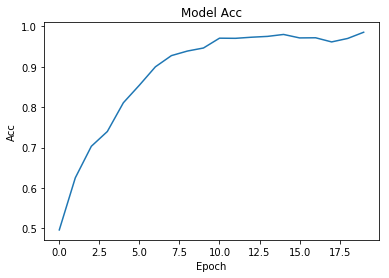

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('Model Acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.show()

In [12]:
model.evaluate(x = test_inputs, y = test_labels, verbose = 1)

324/324 [==============================] - 0s 699us/step


[0.9690166644660043, 0.8611111111111112]

In [13]:
from keras.models import load_model
model.save('tf/saved_models/keras_classfier_1.h5') 
#kmodel = load_model('tf/saved_models/keras_classfier.h5')

In [14]:
model.save_weights('tf/saved_models/keras_classfier_1_weights.h5')

In [15]:
kmodel = Sequential()

kmodel.add(Dense(ss_1,input_shape = (num_features,),kernel_initializer = 'glorot_uniform'))
kmodel.add(Activation('relu'))
kmodel.add(Dropout(0.2))

kmodel.add(Dense(ss_2))
kmodel.add(Activation('relu'))
kmodel.add(Dropout(0.2))

kmodel.add(Dense(ss_3))
kmodel.add(Activation('relu'))
kmodel.add(Dropout(0.2))

kmodel.add(Dense(ss_4))
kmodel.add(Activation('relu'))
kmodel.add(Dropout(0.2))

kmodel.add(Dense(n_classes))
kmodel.add(Activation('softmax'))

In [17]:
optimizer = Adam(lr = lr)
kmodel.load_weights('tf/saved_models/keras_classfier_1_weights.h5')

In [21]:
kmodel.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
kmodel.evaluate(x = test_inputs, y = test_labels, verbose = 1)

324/324 [==============================] - 0s 557us/step


[0.9690166644660043, 0.8611111111111112]